# Analyse des Sentiments

## 1. Introduction

L'analyse des sentiments, apparue au début des années 2000, permet d'analyser de gros volumes de données afin d'extraire des ressentis ou des opinions. L'objectif est de pouvoir produire des statistiques et des outils d'aide à la décision. Les domaines d'applications sont nombreux et nous pouvons par exemple citer la finance, la politique où le marketing (liste non exhaustive).

L'apprentissage automatique (ou machine learning), supervisé ou non, est un outil utilisé pour l'analyse des sentiments. Dans ce rapport, nous allons traiter l'analyse des sentiments via deux problèmes classiques de machine learning, la [classification](https://en.wikipedia.org/wiki/Statistical_classification) et le [clustering](https://en.wikipedia.org/wiki/Cluster_analysis). Nous utiliserons la bibliothèque python [scikit-learn](http://scikit-learn.org/stable/) mais les méthodes utilisées peuvent être facilement appliquées avec d'autres librairies ; ce qui compte c'est la démarche.

## 2. Pré-processing

### 2.1. Généralités

L'étape d'analyse des données est facilitée par les nombreuses bibliothèques disponibles qui sont souvent très intuitives. En revanche, l'étape qui précède l'analyse, le nettoyage des données, est souvent plus longue mais nécessaire. En effet, les données que l'on récupère sont parfois incomplètes, contiennent des caractères inutiles (par exemple des balises HTML) ou n'ont pas toutes la même structure. Et c'est le cas pour les données de [TripAdvisor](http://times.cs.uiuc.edu/~wang296/Data/). Cette étape est donc un passage obligatoire pour avoir des données propres, ce qui est fondamental pour faire de l'apprentissage de façon fiable et confortable. Toutefois, ce n'est pas l'objet de ce document, nous ne nous attarderons donc pas sur ce point.

Une fois que les données sont nettoyées, il ne reste que le texte brut. Néanmoins, certains mots ne sont pas pertinents comme les stop words. L'élimination des stop words est souvent implémentée dans les bibliothèques d'apprentissage toutefois, on peut facilement trouver les [stop words](http://www.ranks.nl/stopwords) d'une langue particulière en cas de besoin.

Enfin, les algorithmes de machine learning n'acceptent en entrée que des données numériques. Avant de pouvoir faire de l'apprentissage sur du texte, il est donc nécessaire de transformer les mots en nombres. L'approche [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) (BoW) permet cette transformation et nous allons la détailler dans la section suivante.

### 2.2. L'approche Bag of Words

Nous avons à notre disposition un corpus de documents, dans notre cas, un ensemble d'avis. La mèthode BoW est constituée de deux étapes : l'apprentissage du vocabulaire et le comptage de l'occurrence de chaque mot. 

Lors de l'apprentissage du vocabulaire, l'algorithme BoW parcourt l'ensemble du corpus et retient les mots les plus fréquemment utilisés. Dans la plupart des implémentations, il est possible de paramétrer le nombre maximum de mots à intégrer dans le vocabulaire. 

Ensuite, pour chaque document, on compte l'occurrence de chaque mot du vocabulaire. Il est souvent plus judicieux de calculer la fréquence de chaque mot plutôt que le nombre d'occurrences. En effet, si nous avons deux documents, un long et un court, traitant du même sujet, le nombre d'apparitions de chaque mot dans chaque document sera différent, conduisant à deux vecteurs différents.

Avec scikit-learn, on procède de la [manière suivante](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) : 

In [2]:
# La fonction TfidfVectorizer permet d'implémenter l'approche Bag of Words.
from sklearn.feature_extraction.text import TfidfVectorizer 

# On initialise le vectorizer. Le paramètre "analyzer" permet de scpécifier ce que nous allons analyser, soit des mots, soit des
# mots composés (n-grams). Dans notre cas, les reviews sont en anglais, on supprime donc tous les stop words anglais. Enfin, nous
# n'analysons pas tous les mots, on se contente des 20 les plus utilisés, pour que cette exemple soit "montrable". En pratique, 
# max_features = 5000 serait largement suffisant.
vect = TfidfVectorizer(analyzer = "word",stop_words='english',max_features = 20)

# Une fois qu'on a réalisé l'initialisation, on peut analyser notre corpus de documents.
vect.fit_transform(corpus)

# On affiche les 20 mots le splus utilisés
for word in vect.get_feature_names():
    print word

area
beach
bed
breakfast
clean
day
food
friendly
location
night
place
pool
resort
room
rooms
service
small
staff
time
walk


Les mots ci-dessus constituent le vocabulaire qui servira de base pour les parties classification et clustering. On remarque que ce n'est peut-être pas un vocabulaire optimal. En effet, on constate la présence des mots "room" et "rooms", il serait donc judicieux de raffiner un peu la partie pré-taitement pour prendre en compte les pluriels.

## 3. Classification

L'objectif de cette section est de classifier les avis des différents hôtels en fonction des deux catégories : positif (1) ou négatif (0). Pour ce faire, nous allons utiliser une [machine à vecteur de support](https://en.wikipedia.org/wiki/Support_vector_machine) (SVM). C'est une méthode classique pour les problèmes de classification. Bien sûr, il en existe d'autres, comme les [forêts aléatoires](https://en.wikipedia.org/wiki/Random_forest) mais le point important n'est pas la méthode mais la démarche qui pourra être appliquée avec n'importe quel outil de classification.

Tout d'abord, on initialise le classifeur.

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-4, n_iter=50, random_state=42)

# Afin de gagner du temps, on peut aussi déclarer une pipeline de la façon suivante
clf = Pipeline([('vect', TfidfVectorizer(analyzer = "word",stop_words='english',max_features = 5000)),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-4, n_iter=50, random_state=42))])

Dans notre cas, nous avons sélectionné un classifieur linéaire, toutefois il est possible de choisir des classifieurs non-linéaires.

La première étape de tout problème d'apprentissage supervisé consiste à entraîner le modèle sur une base d'avis dont nous connaissons déjà la classe (0 ou 1). Trouver une telle base peut être difficile si nous n'en possédons pas déjà. De plus, la construire serait fastidieux car, pour que le modèle soit bien entraîné, elle doit être volumineuse. Dans cet exemple, nous allons entraîner notre modèle sur une base contenant les classifications d'avis cinématographiques. Cela peut paraître surprenant puisque nous voulons classifier des avis concernant des hôtels. Néanmoins, un avis, qu'ils concerne un film, un hôtel, une voiture, contiendra le même type de vocabulaire s'il est positif ou s'il est négatif. C'est pourquoi notre façon de procéder reste valide.

Avant de passer à l'apprentissage, nous avons séparé le fichier de données, contenant 25000 reviews, en deux fichiers de 20000 et 5000 reviews respectivement. L'objectif est d'analyser les performances du modèle en validant l'apprentissage à partir des 20000 reviews sur les 5000.

Avec scikit-learn, la partie apprentissage est réalisée de la façon suivante.

In [4]:
import time
import numpy as np
from sklearn import metrics

# Chargement du fichier contenant les données d'apprentissage
train = pd.read_csv("movies/train/labeledTrainData.csv", header=0,delimiter=",")

# Apprentissage
tps1 = time.clock()
clf = clf.fit(train["review"],train["sentiment"])
tps2 = time.clock()

print('Apprentissage réalisé en %.3f seconds'%(tps2-tps1))
print

# Prédictions
test = pd.read_csv("movies/validation_data/test_validation.csv", header=0,delimiter=',')
tps1 = time.clock()
result = clf.predict(test["review"])
tps2 = time.clock() 
print ('Prédictions réalisées en %.3f seconds'%(tps2 - tps1))
print

# Performances du classifieur
valid = pd.read_csv("movies/validation_data/validation.csv", header=0, delimiter=",") # Fichier contenant les sentiments valides 
print ('Taux de bonnes prédictions : %.2f '%(np.mean(result == valid["sentiment"])*100))
print
print 'Matrice de confusion :'
metrics.confusion_matrix(valid["sentiment"],result)

Apprentissage réalisé en 5.452 seconds

Prédictions réalisées en 1.175 seconds

Taux de bonnes prédictions : 91.46 

Matrice de confusion :


array([[2243,  218],
       [ 209, 2330]])

Le taux d'apprentissage est tout à fait satisfaisant. Maintenant, pour chaque review de chaque hôtel, il suffit d'appliquer le classifieur : clf.predict(my_hotel["review"]).

## 4. Clustering

Pour clusteriser les avis cinématographiques, nous allons utiliser la méthode des [K-means](https://en.wikipedia.org/wiki/K-means_clustering). Deux choix sont alors possibles. Soit nous pouvons utiliser le partitionnement K-means directement sur les revues (après avoir appliqué la méthode Bag of Words), soit nous pouvons d'abord extraire les sujets les plus discutés et les passer en paramètres de la méthode K-means. Avec la deuxième option, les centroïdes (centre des clusters) ne seront pas recherchés par la méthode des K-means. Cette dernière se contentera de regrouper les avis dans les catégories définies par les centroïdes. C'est cette dernière approche que nous allons utiliser.

### 4.1. Extraction de sujets

Pour extraire les principaux sujets, nous allons utiliser la méthode appelée [Non-Negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) (NMF). Encore une fois, il n'y a pas unicité dans le choix de la méthode, nous pourrions très bien utiliser l'approche [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA).

In [9]:
from sklearn.decomposition import NMF
import random

n_samples = 1000 # Nombre d'échantillons que l'on veut analyser pour extraire des sujets
n_features = 50 # Nombre de mots que l'on veut dans le vocabulaire pour le BoW
n_topics = 10 # Nombre de sujets que l'on veut extraire      
n_top_words = 5 # Nombre de mots les plus représentatifs d'un sujet (pour l'affichage)

file_list =[f for f in os.listdir("data/")] # On récupère la liste des fichiers contenus dans le dossier data
samples_id = [file_list[id] for id in random.sample(range(len(file_list)), n_samples)] # On en séléctionne n_samples au hasard

# Mise en forme des reviews pour les passer en paramètre des différentes fonctions.
reviews = []
for f in samples_id:
    review = pd.read_csv("data/"+f, header=0,delimiter=",")
    reviews.append([review["Content"][i] for i in range(len(review))])  
    
reviews = [el for index in range(len(reviews))
              for el in reviews[index]]

# Vectorisation des avis.
vect = TfidfVectorizer(analyzer = "word",stop_words="english",max_features = n_features)
BoW = vect.fit_transform(reviews)

# Extraction des sujets
nmf = NMF(n_components=n_topics, tol = 1e-5,random_state=1).fit(BoW)

# On affiche les 5 mots les plus représentatifs de chaque sujets
for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([vect.get_feature_names()[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic #0:
room bed bathroom floor view
Topic #1:
resort food beautiful people time
Topic #2:
beach food beautiful restaurants water
Topic #3:
service excellent food restaurant experience
Topic #4:
rooms small clean lobby large
Topic #5:
night time day check people
Topic #6:
staff friendly wonderful clean recommend
Topic #7:
pool area bar view lobby
Topic #8:
location breakfast clean walk close
Topic #9:
place people don better food


Encore une fois, nous pouvons remarquer que l'étape de pré-traitement pourrait-être plus soignée. Malgré cela, la NFM est capable d'extraire quelques sujets pertinents comme par exemple le sujet 9 concernant la location.

### 4.2. Regroupement des reviews

Maintenant que nous avons identifié les sujets les plus importants, nous allons regrouper tous les avis de tous les hôtels dans les 10 catégories extraites à l'étape précédente. Les résultats seront enregistrés dans le dossier "clustering", nous conserverons le nom du fichier d'origine. Le format des fichiers de sortie sera {ReviewID:Cluster}, où Cluster sera un entier allant de 0 à 9.

In [11]:
from sklearn.cluster import KMeans

# Définition de la pipeline
km_clf = Pipeline([('vect', TfidfVectorizer(analyzer = "word",stop_words='english',max_features = n_features)),
                   ('clf', KMeans(init=nmf.components_, max_iter=20, n_init=1))])

# Apprentissage avec les k-means
file_list =[f for f in os.listdir("data/")]

tps1 = time.clock() 
for f in file_list:
    dt = pd.read_csv("data/"+f,header=0,delimiter=',')
        
    if len(dt["Content"])>nmf.components_.shape[0]:
        km_clf.fit(dt["Content"])
        output = pd.DataFrame({"id":dt["ReviewID"], "cluster":km_clf.named_steps['clf'].labels_} ).to_csv("clustering/"+f, index=False, quoting=3 )
            
tps2 = time.clock()
print ("Clustering réalisé en %.3f seconds"%(tps2 - tps1))

Clustering réalisé en 67.601 seconds


Une fois le clustering effectué, on peut afficher, pour chaque hôtel, le nombre d'avis dans chaque cluster. Dans notre cas, on va se contenter des 20 premiers hôtels.

Tout d'abord, on calcul, pour chaque hôtel, combien de reviews on compte par cluster.

In [12]:
# Génération de la heat map pour les 20 premiers hotels
file_list =[f for f in os.listdir("clustering/")]

heat = []

count = 0
for f in file_list:
    if count == 20: # Ce compteur est là pour ne prendre en compte que les 20 premiers hotels.
        break
    
    data = pd.read_csv("clustering/"+f, header=0, delimiter=",")
    
    clusters = [0 for i in range(n_topics)]

    for i in data["cluster"]:
        clusters[i] += 1
    
    heat.append(clusters)
    count +=1
    
heat = np.array(heat)

Ensuite, on réalise la heatmap (il y a des moyens plus simple, là, le but était juste de customiser un peu l'affichage).

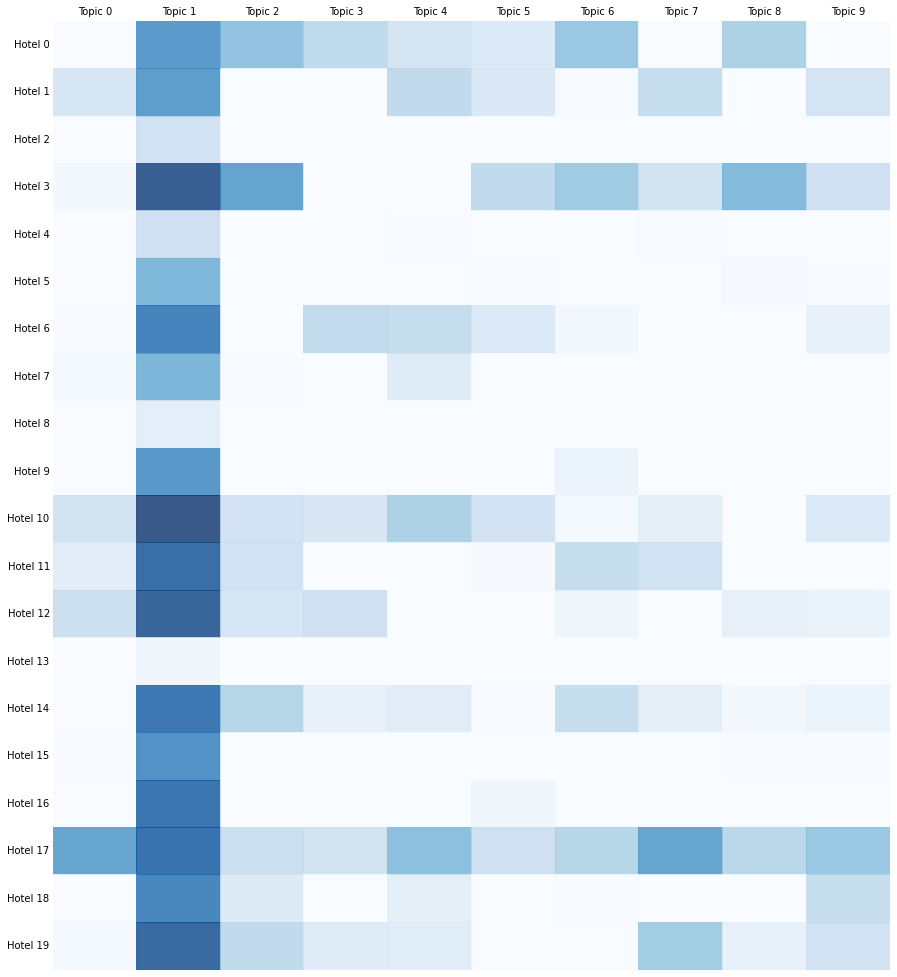

In [13]:
# Affichage de la heatmap
import matplotlib.pyplot as plt
from urllib2 import urlopen 
%matplotlib inline

fig, ax = plt.subplots()
heatmap = ax.pcolor(heat, cmap=plt.cm.Blues, alpha=0.8)

# Format de la fenêtre d'affichage
fig = plt.gcf()
fig.set_size_inches(15,17)
ax.set_frame_on(False)

# On positionne les labels des axes au milieu des cellules
ax.set_yticks(np.arange(heat.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(heat.shape[1])+0.5, minor=False)

# Affichage "tableau"
ax.invert_yaxis()
ax.xaxis.tick_top()

# Labels
labels_x = ['Topic '+ str(i) for i in range(n_topics)]
labels_y = ['Hotel '+ str(i) for i in range(heat.shape[0])]
ax.set_xticklabels(labels_x, minor=False) 
ax.set_yticklabels(labels_y, minor=False)

ax.grid(False)

# On supprime les tirets
ax = plt.gca()

for t in ax.xaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False 
for t in ax.yaxis.get_major_ticks(): 
    t.tick1On = False 
    t.tick2On = False 